<a href="https://colab.research.google.com/github/droidadroit/age-and-gender-classification/blob/master/AgeGender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Directory structure

content  
-------- gdrive  
---------------- My Drive  
------------------------ **AgeGenderClassification**  
-------------------------------- **data**  
-------------------------------- **models**   
-------------------------------- **leviHassnerAgeGender.ipynb**


In [ ]:
#!pip3 install torch torchvision torchaudio
# install libraries

## Imports

In [ ]:
import torch
import torch.autograd.variable as Variable
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision.utils as utils
from torch.utils.data import Dataset, DataLoader

In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
from shutil import copyfile

# Preparing dataloaders

In [ ]:
PATH_TO_FOLDS = "/content/gdrive/My Drive/AgeGenderClassification/data/train_val_txt_files_per_fold"
PATH_TO_DATA = "/content/gdrive/My Drive/AgeGenderClassification/data"
PATH_TO_IMAGE_FOLDERS = PATH_TO_DATA + "/aligned"

### Creating a Dataset class

In [ ]:
class AdienceDataset(Dataset):

    def __init__(self, txt_file, root_dir, transform):
        self.txt_file = txt_file
        self.root_dir = root_dir
        self.transform = transform
        self.data = self.read_from_txt_file()

    def __len__(self):
        return len(self.data)

    def read_from_txt_file(self):
        data = []
        f = open(self.txt_file)
        for line in f.readlines():
            image_file, label = line.split()
            label = int(label)
            if 'gender' in self.txt_file:
                label += 8
            data.append((image_file, label))
        return data

    def __getitem__(self, idx):
        img_name, label = self.data[idx]
        image = Image.open(self.root_dir + '/' + img_name)

        if self.transform:
            image = self.transform(image)

        return {
            'image': image,
            'label': label
        }

### Transforms
Every image is first resized to a `256x256` image and then cropped to a `227x227` image before being fed to the network.

**`transforms_list`** is the list of transforms we would like to apply to the input data. Apart from training the neural network without any transformations, we can also train the network using the following transforms (also called as data augmentation techniques):
*   random horizontal flip
*   random crop and random horizontal flip

In [ ]:
transforms_list = [
    transforms.Resize(256),
    transforms.CenterCrop(227),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.RandomCrop(227)
]

transforms_dict = {
    'train': {
        0: list(transforms_list[i] for i in [0, 1, 3]),        # no transformation
        1: list(transforms_list[i] for i in [0, 1, 2, 3]),     # random horizontal flip
        2: list(transforms_list[i] for i in [0, 4, 2, 3])      # random crop and random horizontal flip
    },
    'val': {
        0: list(transforms_list[i] for i in [0, 1, 3])
    },
    'test': {
        0: list(transforms_list[i] for i in [0, 1, 3])
    }
}

### Dataloader

In [ ]:
def get_dataloader(s, c, fold, transform_index, minibatch_size):

    txt_file = f'{PATH_TO_FOLDS}/test_fold_is_{fold}/{c}_{s}.txt'
    root_dir = PATH_TO_IMAGE_FOLDERS

    transformed_dataset = AdienceDataset(txt_file, root_dir,
                                         transforms.Compose(transforms_dict[s][transform_index]))
    dataloader = DataLoader(transformed_dataset, batch_size=minibatch_size, shuffle=True, num_workers=2)

    return dataloader

# Network

##Using the GPU

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
device

device(type='cuda', index=0)

In [ ]:
PATH_TO_MODELS = "/content/gdrive/My Drive/AgeGenderClassification/models"

## Defining the network
This is the network as described in the paper

In [ ]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(3, 96, 7, stride = 4, padding = 1)
        self.pool1 = nn.MaxPool2d(3, stride = 2, padding = 1)
        self.norm1 = nn.LocalResponseNorm(size = 5, alpha = 0.0001, beta = 0.75)

        self.conv2 = nn.Conv2d(96, 256, 5, stride = 1, padding = 2)
        self.pool2 = nn.MaxPool2d(3, stride = 2, padding = 1)
        self.norm2 = nn.LocalResponseNorm(size = 5, alpha = 0.0001, beta = 0.75)

        self.conv3 = nn.Conv2d(256, 384, 3, stride = 1, padding = 1)
        self.pool3 = nn.MaxPool2d(3, stride = 2, padding = 1)
        self.norm3 = nn.LocalResponseNorm(size = 5, alpha = 0.0001, beta = 0.75)

        self.fc1 = nn.Linear(18816, 512)
        self.dropout1 = nn.Dropout(0.5)

        self.fc2 = nn.Linear(512, 512)
        self.dropout2 = nn.Dropout(0.5)

        self.fc3 = nn.Linear(512, 10)

        self.apply(weights_init)


    def forward(self, x):
        x = F.leaky_relu(self.conv1(x))
        x = self.pool1(x)
        x = self.norm1(x)

        x = F.leaky_relu(self.conv2(x))
        x = self.pool2(x)
        x = self.norm2(x)

        x = F.leaky_relu(self.conv3(x))
        x = self.pool3(x)
        x = self.norm3(x)

        x = x.view(-1, 18816)

        x = self.fc1(x)
        x = F.leaky_relu(x)
        x = self.dropout1(x)

        x = self.fc2(x)
        x = F.leaky_relu(x)
        x = self.dropout2(x)

        x = F.log_softmax(self.fc3(x), dim=1)

        return x

In [ ]:
def weights_init(m): # initialise weights
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0, std=1e-2)

In [ ]:
criterion = nn.NLLLoss()

In [ ]:
m = Net()
print(m)

Net(
  (conv1): Conv2d(3, 96, kernel_size=(7, 7), stride=(4, 4), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (norm1): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=1.0)
  (conv2): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (norm2): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=1.0)
  (conv3): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (norm3): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=1.0)
  (fc1): Linear(in_features=18816, out_features=512, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
)


## Hyperparameters
While the **`minibatch_size`** and **`lr`** are obtained from the paper, **`num_epochs`** is set empirically

In [ ]:
minibatch_size = 50
num_epochs = 5
lr = 0.0001  # initial learning rate

## Training the network


In [ ]:
def train(net, train_dataloader, epochs, filename, checkpoint_frequency, val_dataloader=None):

    net.train()
    optimizer = optim.Adam(net.parameters(), lr)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10000])

    training_loss, validation_loss = [], []
    checkpoint = 0
    iteration = 0
    running_loss = 0

    for epoch in range(epochs):

        for i, batch in enumerate(train_dataloader):
            scheduler.step()
            optimizer.zero_grad()
            images, labels = batch['image'].to(device), batch['label'].to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)
            running_loss += float(loss.item())
            loss.backward()
            optimizer.step()

            if (iteration+1) % checkpoint_frequency == 0 and val_dataloader is not None:
                training_loss.append(running_loss/checkpoint_frequency)
                validation_loss.append(validate(net, val_dataloader))
                print(f'minibatch:{i}, epoch:{epoch}, iteration:{iteration}, training_error:{training_loss[-1]}, validation_error:{validation_loss[-1]}')
                checkpoint += 1
                running_loss = 0

            iteration += 1


    save_network(net, f'{filename}_checkpoint{checkpoint}') # save model
    return net, training_loss, validation_loss

## Validation
We evaluate the performance (in terms of loss) of the trained network on validation set.

In [ ]:
def validate(net, dataloader):
    net.train()
    total_loss = 0
    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            images, labels = batch['image'].to(device), batch['label'].to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)
            total_loss += float(loss.item())

    return total_loss/(i+1)

In [ ]:
def get_validation_error(c, fold, train_transform_index):
    filename = get_model_filename(c, fold, train_transform_index)
    net = Net().to(device)
    net.load_state_dict(torch.load(f'{PATH_TO_MODELS}/{filename}'))
    return validate(net, get_dataloader('val', c, fold, 0, minibatch_size))

## Testing
We evaluate the performance (in terms of accuracy) of the trained network on the test set.

In [ ]:
def test(net, dataloader, c):
    result = {
        'exact_match': 0,
        'total': 0
    }
    if c == 'age':
        result['one_off_match'] = 0

    total_loss = 0

    with torch.no_grad():
        net.eval()
        for i, batch in enumerate(dataloader):
            images, labels = batch['image'].to(device), batch['label'].to(device)
            outputs = net(images)

            loss = criterion(outputs, labels)
            total_loss += float(loss.item())

            outputs = torch.tensor(list(map(lambda x: torch.max(x, 0)[1], outputs))).to(device)
            result['total'] += len(outputs)
            result['exact_match'] += sum(outputs == labels).item()
            if c == 'age':
                result['one_off_match'] += (sum(outputs==labels) +
                                            sum(outputs==labels-1) +
                                            sum(outputs==labels+1)).item()

    result['test_loss'] = total_loss/(i+1)
    return result

## Saving the network

In [ ]:
def save_network(net, filename):
    torch.save(net.state_dict(), f'{PATH_TO_MODELS}/{filename}.pt')

# Execution

### Picking the best model for a fold
**`train_save()`** trains the network using the **`train()`** function. This function also plots a graph of training and validation errors over the iterations.



In [ ]:
def train_save(c, fold, train_transform_index, checkpoint_frequency=200):

    trained_net, training_loss, validation_loss = train(
        Net().to(device),
        get_dataloader('train', c, fold, train_transform_index, minibatch_size),
        num_epochs,
        f'{fold}_{c}_train_{train_transform_index}',
        checkpoint_frequency,
        get_dataloader('val', c, fold, 0, minibatch_size)
    )

    plt.plot(list(map(lambda x: checkpoint_frequency * x, (list(range(1, len(validation_loss)+1))))), validation_loss, label='validation_loss')
    plt.plot(list(map(lambda x: checkpoint_frequency * x, (list(range(1, len(training_loss)+1))))), training_loss, label='training_loss')
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
    plt.xlabel('iterations')
    plt.ylabel('loss')
    plt.show()


    return validation_loss

In [ ]:
def choose_model_with_least_val_error(c, fold, train_transform_index, validation_loss):
    index = validation_loss.index(min(validation_loss))
    filename = f'{fold}_{c}_train_{train_transform_index}'
    for file in os.listdir(PATH_TO_MODELS):
        if file.startswith(filename):
            if file.startswith(f'{filename}_checkpoint{index}'):
                pass
            else:
                os.remove(f'{PATH_TO_MODELS}/{file}')

### Picking the best model among all the folds

Using **`pick_best_model()`**, we can pick the model among various folds that gives us the best validation accuracy. The best model's name is appended with **_best **in the **models** directory.

In [ ]:
def pick_best_model(c):

    def fn_filter(file):
        file_split = file.split('_')
        return True if (len(file_split) == 5 and file_split[1] == c) else False

    def fn_map(file):
        file_split = file.split('_')
        return get_validation_error(c, file_split[0], file_split[3])

    files = list(filter(fn_filter, os.listdir(PATH_TO_MODELS)))
    val_errors = list(map(fn_map, files))
    min_val_error, file = min(zip(val_errors, files))
    best_model = f'{PATH_TO_MODELS}/{file.split(".")[0]}_best.pt'
    copyfile(f'{PATH_TO_MODELS}/{file}', best_model)

    print(f'Picking {best_model} as the best model for {c}...')

### Calculating performance/accuracy

We can check the performance of any model using the **`get_performance()`** function.




In [ ]:
def get_performance(c):

    file = get_best_model_filename(c).split('_')
    return get_performance_of_a_model('test', file[1], file[0], file[3])

In [ ]:
def get_best_model_filename(c):
    def fn_filter(file):
        file_split = file.split('_')
        return True if (len(file_split) == 6 and file_split[1] == c) else False

    return list(filter(fn_filter, os.listdir(PATH_TO_MODELS)))[0]

In [ ]:
def get_performance_of_a_model(s, c, fold, train_transform_index):

    filename = get_model_filename(c, fold, train_transform_index)
    net = Net().to(device)
    net.load_state_dict(torch.load(f'{PATH_TO_MODELS}/{filename}'))
    performance = test(
        net,
        get_dataloader(s, c, fold, 0, minibatch_size),
        c
    )
    if c == 'age':
        return {
            'accuracy': performance['exact_match']/performance['total'],
            'one-off accuracy': performance['one_off_match']/performance['total'],
            'test loss': performance['test_loss']
        }
    elif c == 'gender':
        return {
            'accuracy': performance['exact_match']/performance['total'],
            'test loss': performance['test_loss']
        }

In [ ]:
def get_model_filename(c, fold, train_transform_index):
    start_of_filename = f'{fold}_{c}_train_{train_transform_index}_checkpoint'
    for file in os.listdir(PATH_TO_MODELS):
        if file.startswith(start_of_filename):
            return file

##Performing training and testing
For age and gender classification, train on 5 folds and select the model that gives the smallest validation error.

age fold 0


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


minibatch:199, epoch:0, iteration:199, training_error:2.0223829454183577, validation_error:1.9895510260875409
minibatch:162, epoch:1, iteration:399, training_error:1.979906315803528, validation_error:1.9609563946723938
minibatch:125, epoch:2, iteration:599, training_error:1.9427351880073547, validation_error:1.8856531519156237
minibatch:88, epoch:3, iteration:799, training_error:1.8438424950838088, validation_error:1.7708801168661852
minibatch:51, epoch:4, iteration:999, training_error:1.699276727437973, validation_error:1.6600990799757152


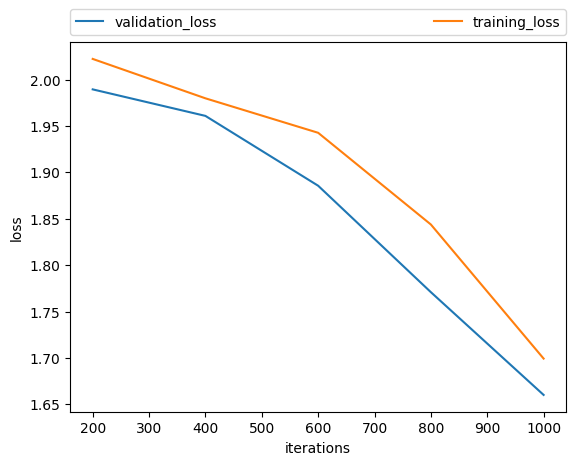

age fold 1
minibatch:199, epoch:0, iteration:199, training_error:1.963501986861229, validation_error:1.953346141453447
minibatch:141, epoch:1, iteration:399, training_error:1.9155101704597473, validation_error:1.9047289100186577
minibatch:83, epoch:2, iteration:599, training_error:1.851072568297386, validation_error:1.822380259119231
minibatch:25, epoch:3, iteration:799, training_error:1.7152573096752166, validation_error:1.651734056143925
minibatch:225, epoch:3, iteration:999, training_error:1.6072633689641953, validation_error:1.5716029117847312
minibatch:167, epoch:4, iteration:1199, training_error:1.536102364063263, validation_error:1.4903190834768887


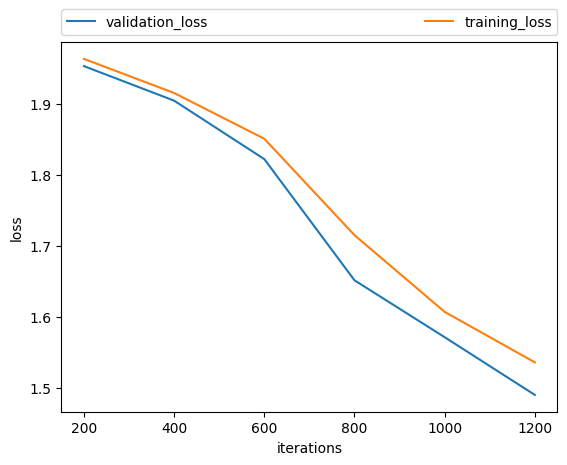

age fold 2
minibatch:199, epoch:0, iteration:199, training_error:1.991455333828926, validation_error:1.9463674446632122
minibatch:145, epoch:1, iteration:399, training_error:1.9176324248313903, validation_error:1.8819527831570855
minibatch:91, epoch:2, iteration:599, training_error:1.8587515598535538, validation_error:1.811225570481399
minibatch:37, epoch:3, iteration:799, training_error:1.7530036282539367, validation_error:1.650977640316404
minibatch:237, epoch:3, iteration:999, training_error:1.637798643708229, validation_error:1.5646798035194134
minibatch:183, epoch:4, iteration:1199, training_error:1.5548031502962112, validation_error:1.506907919357563


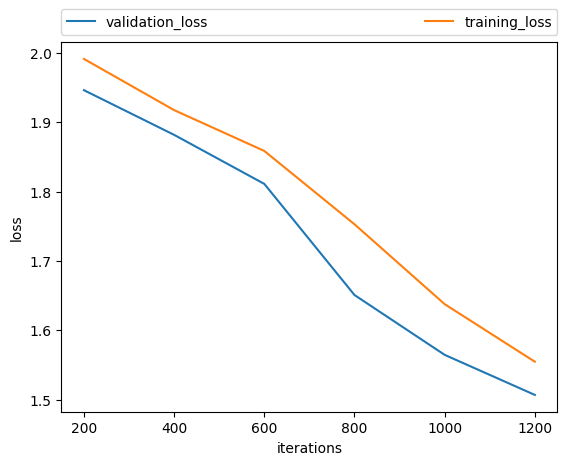

age fold 3
minibatch:199, epoch:0, iteration:199, training_error:1.9911979484558104, validation_error:1.9298263430595397
minibatch:139, epoch:1, iteration:399, training_error:1.9436317241191865, validation_error:1.9014715751012166
minibatch:79, epoch:2, iteration:599, training_error:1.8757076394557952, validation_error:1.812026838461558
minibatch:19, epoch:3, iteration:799, training_error:1.7519182080030442, validation_error:1.6594402035077414
minibatch:219, epoch:3, iteration:999, training_error:1.6282093459367752, validation_error:1.5696833888689676
minibatch:159, epoch:4, iteration:1199, training_error:1.5592081612348556, validation_error:1.4888781189918519


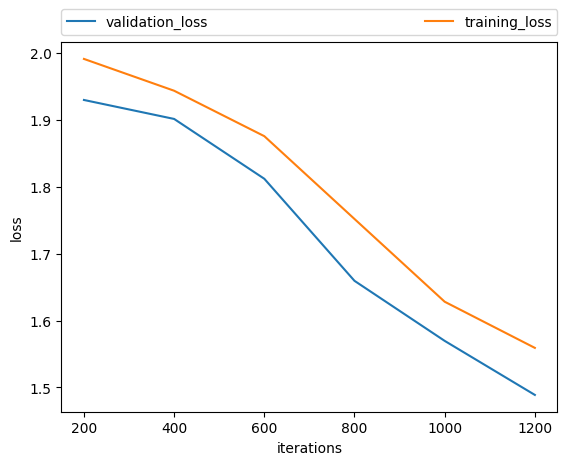

age fold 4
minibatch:199, epoch:0, iteration:199, training_error:1.98773428440094, validation_error:1.9658047556877136
minibatch:151, epoch:1, iteration:399, training_error:1.9358999067544937, validation_error:1.9259140023163386
minibatch:103, epoch:2, iteration:599, training_error:1.8792740076780319, validation_error:1.8372117791857039
minibatch:55, epoch:3, iteration:799, training_error:1.7701420623064041, validation_error:1.6815017291477747
minibatch:7, epoch:4, iteration:999, training_error:1.632935318350792, validation_error:1.5431425443717413
minibatch:207, epoch:4, iteration:1199, training_error:1.530793358683586, validation_error:1.4616724593298775


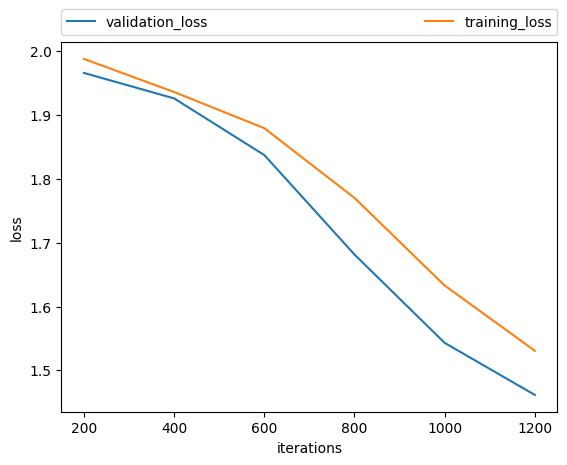

Picking /content/gdrive/My Drive/AgeGenderClassification/models/4_age_train_2_checkpoint5_best.pt as the best model for age...
Time taken for training on age: 6914.114746332169
gender fold 0
minibatch:199, epoch:0, iteration:199, training_error:0.8264483872056008, validation_error:0.6942115668897275
minibatch:153, epoch:1, iteration:399, training_error:0.696803038418293, validation_error:0.668542727276131
minibatch:107, epoch:2, iteration:599, training_error:0.6566852962970734, validation_error:0.6316832966274686
minibatch:61, epoch:3, iteration:799, training_error:0.6353102108836174, validation_error:0.6212546935787907
minibatch:15, epoch:4, iteration:999, training_error:0.6181682628393174, validation_error:0.5939949618445503
minibatch:215, epoch:4, iteration:1199, training_error:0.5978733536601066, validation_error:0.569211118751102


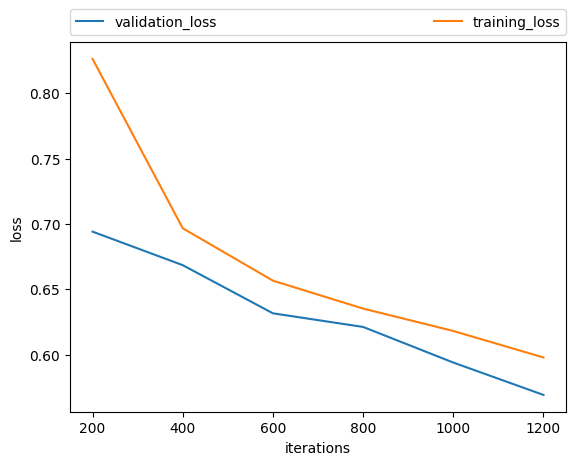

gender fold 1
minibatch:199, epoch:0, iteration:199, training_error:0.8227571693062782, validation_error:0.7060027122497559
minibatch:147, epoch:1, iteration:399, training_error:0.7019514775276184, validation_error:0.6959878185699726
minibatch:95, epoch:2, iteration:599, training_error:0.6887559688091278, validation_error:0.6719076982859907
minibatch:43, epoch:3, iteration:799, training_error:0.651827202141285, validation_error:0.6468666730255916
minibatch:243, epoch:3, iteration:999, training_error:0.6337728291749954, validation_error:0.6092228221482244
minibatch:191, epoch:4, iteration:1199, training_error:0.5974839216470719, validation_error:0.5862094831877741


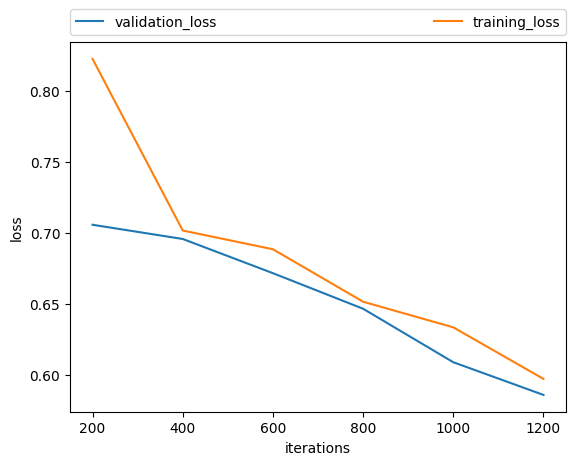

gender fold 2
minibatch:199, epoch:0, iteration:199, training_error:0.822901406288147, validation_error:0.7053771635581707
minibatch:139, epoch:1, iteration:399, training_error:0.6931109002232552, validation_error:0.666722414822414
minibatch:79, epoch:2, iteration:599, training_error:0.6554859039187432, validation_error:0.6255627983602984
minibatch:19, epoch:3, iteration:799, training_error:0.6327857258915901, validation_error:0.6213123890860327
minibatch:219, epoch:3, iteration:999, training_error:0.6058196069300175, validation_error:0.58367376286408
minibatch:159, epoch:4, iteration:1199, training_error:0.5816674695909023, validation_error:0.5426020992213282


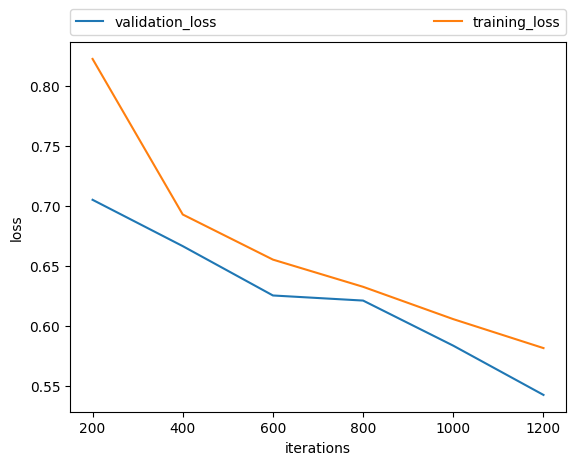

gender fold 3
minibatch:199, epoch:0, iteration:199, training_error:0.8170607271790504, validation_error:0.7097995815605953
minibatch:141, epoch:1, iteration:399, training_error:0.7001394146680832, validation_error:0.7035752123799818
minibatch:83, epoch:2, iteration:599, training_error:0.6817349445819855, validation_error:0.6672248532032145
minibatch:25, epoch:3, iteration:799, training_error:0.6574720531702042, validation_error:0.6259143373061871
minibatch:225, epoch:3, iteration:999, training_error:0.6356393513083458, validation_error:0.6220650960659159
minibatch:167, epoch:4, iteration:1199, training_error:0.6207978519797325, validation_error:0.5844172444836847


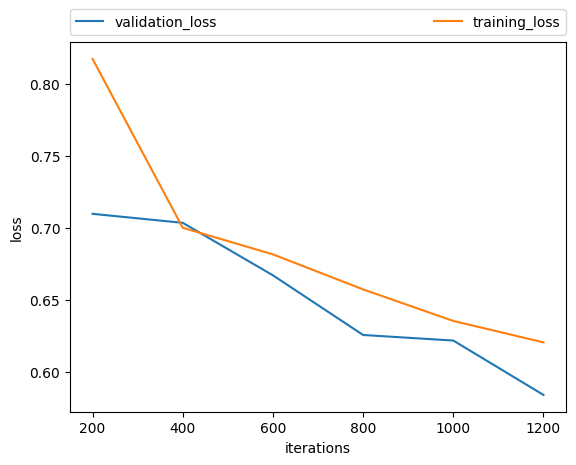

gender fold 4
minibatch:199, epoch:0, iteration:199, training_error:0.8317889288067818, validation_error:0.7035679776093056
minibatch:144, epoch:1, iteration:399, training_error:0.7048798242211342, validation_error:0.6905929014600557
minibatch:89, epoch:2, iteration:599, training_error:0.6708667507767677, validation_error:0.652753312012245
minibatch:34, epoch:3, iteration:799, training_error:0.643800348341465, validation_error:0.6184286845141443
minibatch:234, epoch:3, iteration:999, training_error:0.6203675350546837, validation_error:0.6009143282627237
minibatch:179, epoch:4, iteration:1199, training_error:0.5927105078101158, validation_error:0.5795556892608774


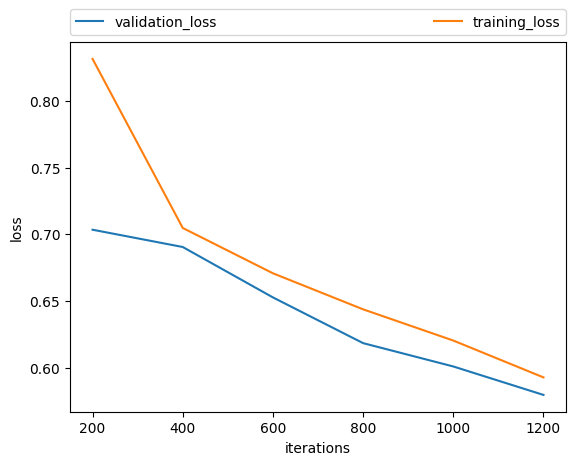

Picking /content/gdrive/My Drive/AgeGenderClassification/models/2_gender_train_2_checkpoint5_best.pt as the best model for gender...
Time taken for training on gender: 3958.3252561092377


In [ ]:
import time

for model_type in ['age', 'gender']:

    start_time = time.time()

    for fold in range(5):
      print(f"{model_type} fold {fold}")
      train_save(model_type, fold, 2)
    pick_best_model(model_type)

    end_time = time.time()
    print(f"Time taken for training on {model_type}:", end_time - start_time)

In [ ]:
get_performance('age')

{'accuracy': 0.42621175196317357,
 'one-off accuracy': 0.7140536149471974,
 'test loss': 1.5805055934029657}

In [ ]:
get_performance('gender')

{'accuracy': 0.6803509871513632, 'test loss': 0.5979710198007524}